# Choke Point Notebook

The objective of this analysis is to examine the impact of the Red Sea Conflict on maritime trade statistics derived from AIS data.  

We process transit calls and estimated trade volume from the IMF's [PortWatch](https://portwatch.imf.org/) platform for key areas of interest. We then produce charts to inspect trends and calculate percentage changes from a historical baseline.

## Setup

Import libraries and define output paths to save graphs and tables.

In [1]:
import os
import sys
from os.path import join, exists

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

import git
import time

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")
sys.path.append(join(git_root, "src", "red-sea-monitoring"))
from utils import *

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, percent_format
import plotnine

plotnine.options.figure_size = (10, 8)

output_dir = (
    r"C:\Users\WB514197\WBG\Development Data Partnership - Red Sea Maritime Monitoring"
)
charts_dir = join(git_root, "reports")

## Data

### Locations

Retrieve chokopoints locations dataset and select the three areas of interest.

In [2]:
chokepoints = get_chokepoints()

# List areas of interest
aois = ["Bab el-Mandeb Strait", "Cape of Good Hope", "Suez Canal"]

chokepoints_sel = chokepoints.loc[chokepoints.portname.isin(aois)].copy()
chokepoints_sel

,portid,portname,country,ISO3,continent,fullname,lat,lon,vessel_count_total,vessel_count_container,...,vessel_count_tanker,industry_top1,industry_top2,industry_top3,share_country_maritime_import,share_country_maritime_export,LOCODE,pageid,countrynoaccents,ObjectId
0,chokepoint1,Suez Canal,None,None,None,Suez Canal,30.593346,32.436882,22217,6455,...,6919,"Petroleum, Chemical and Non-Metallic Mineral P...",Mining and Quarrying,Agriculture,None,None,None,c57c79bf612b4372b08a9c6ea9c97ef0,None,1
3,chokepoint4,Bab el-Mandeb Strait,None,None,None,Bab el-Mandeb Strait,12.788597,43.349545,22519,6280,...,7386,"Petroleum, Chemical and Non-Metallic Mineral P...",Mining and Quarrying,Agriculture,None,None,None,6b1814d64903461b98144a6cc25eb79c,None,4
6,chokepoint7,Cape of Good Hope,None,None,None,Cape of Good Hope,-34.927286,20.882737,17332,2018,...,3973,Mining and Quarrying,"Petroleum, Chemical and Non-Metallic Mineral P...",Agriculture,None,None,None,edf18f455a2b4637a3632b6af201abe9,None,7


In [3]:
chokepoints_sel.loc[:, "geometry"] = chokepoints_sel.apply(
    lambda x: Point(x.lon, x.lat), axis=1
)
chokepoints_sel = gpd.GeoDataFrame(
    chokepoints_sel, geometry="geometry", crs="EPSG:4326"
)
# chokepoints_sel.to_file(join(output_dir, "chokepoints.shp"), driver='ESRI Shapefile')

### Map of Choke Points

In [4]:
chokepoints_sel[
    [
        "geometry",
        "portname",
        "vessel_count_total",
        "vessel_count_container",
        "vessel_count_dry_bulk",
        "vessel_count_general_cargo",
        "vessel_count_RoRo",
        "vessel_count_tanker",
        "industry_top1",
        "industry_top2",
        "industry_top3",
    ]
].explore(
    column="portname",
    cmap="Dark2",
    marker_kwds={"radius": 15},
    tiles="Esri Ocean Basemap",
    legend_kwds={"loc": "upper right", "caption": "Choke Points"},
)

### AIS Data

Pull AIS data for selected locations.

In [5]:
ids = list(chokepoints_sel.portid)
df_chokepoints = get_chokepoint_data(ids)
df_chokepoints.loc[:, "ymd"] = df_chokepoints.date.dt.strftime("%Y-%m-%d")
df_chokepoints.to_csv(
    join(
        output_dir,
        "data",
        "PortWatch-data",
        f'chokepoints_data_{time.strftime("%Y_%m_%d")}.csv',
    ),
    index=False,
)

## Data Analysis

### Data Smoothening

In [6]:
# df = pd.read_csv(join(output_dir, f'chokepoints_data_{time.strftime("%m_%d_%Y")}.csv'))
df = pd.read_csv(
    join(
        output_dir,
        "data",
        "PortWatch-data",
        f'chokepoints_data_{time.strftime("%Y_%m_%d")}.csv',
    )
)
df.date = pd.to_datetime(df.date)
df = df.loc[df.date >= "2019-01-01"].copy()

In [7]:
df.tail(2)

,portid,portname,date,n_cargo,n_tanker,n_total,capacity,ObjectId,ymd
5695,chokepoint7,Cape of Good Hope,2024-03-11 20:00:00,52,16,68,5.324244e+06,20888,2024-03-11
5696,chokepoint7,Cape of Good Hope,2024-03-12 20:00:00,72,20,92,1.002038e+07,20889,2024-03-12


Calculate 7-day rolling average and create month-day attribute.

In [8]:
df = (
    df.groupby("portname")[["n_tanker", "n_cargo", "n_total", "capacity", "date"]]
    .rolling(7, center=True, min_periods=1, on="date")
    .mean()
)
df.reset_index(inplace=True)
df.drop("level_1", axis=1, inplace=True)
df.loc[:, "ymd"] = df.date.dt.strftime("%Y-%m-%d")
df.loc[:, "md"] = df.date.dt.strftime("%m-%d")

In [9]:
df.head(2)

,portname,capacity,n_cargo,n_tanker,n_total,date,ymd,md
0,Bab el-Mandeb Strait,4.149714e+06,42.0,18.25,60.25,2019-01-01 19:00:00,2019-01-01,01-01
1,Bab el-Mandeb Strait,4.129687e+06,40.6,18.20,58.80,2019-01-02 19:00:00,2019-01-02,01-02


### Figure: AIS Transit Calls in Key Areas, Historical

In [10]:
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [11]:
if not exists(join(charts_dir, "chokepoints")):
    os.makedirs(join(charts_dir, "chokepoints"), mode=0o777)

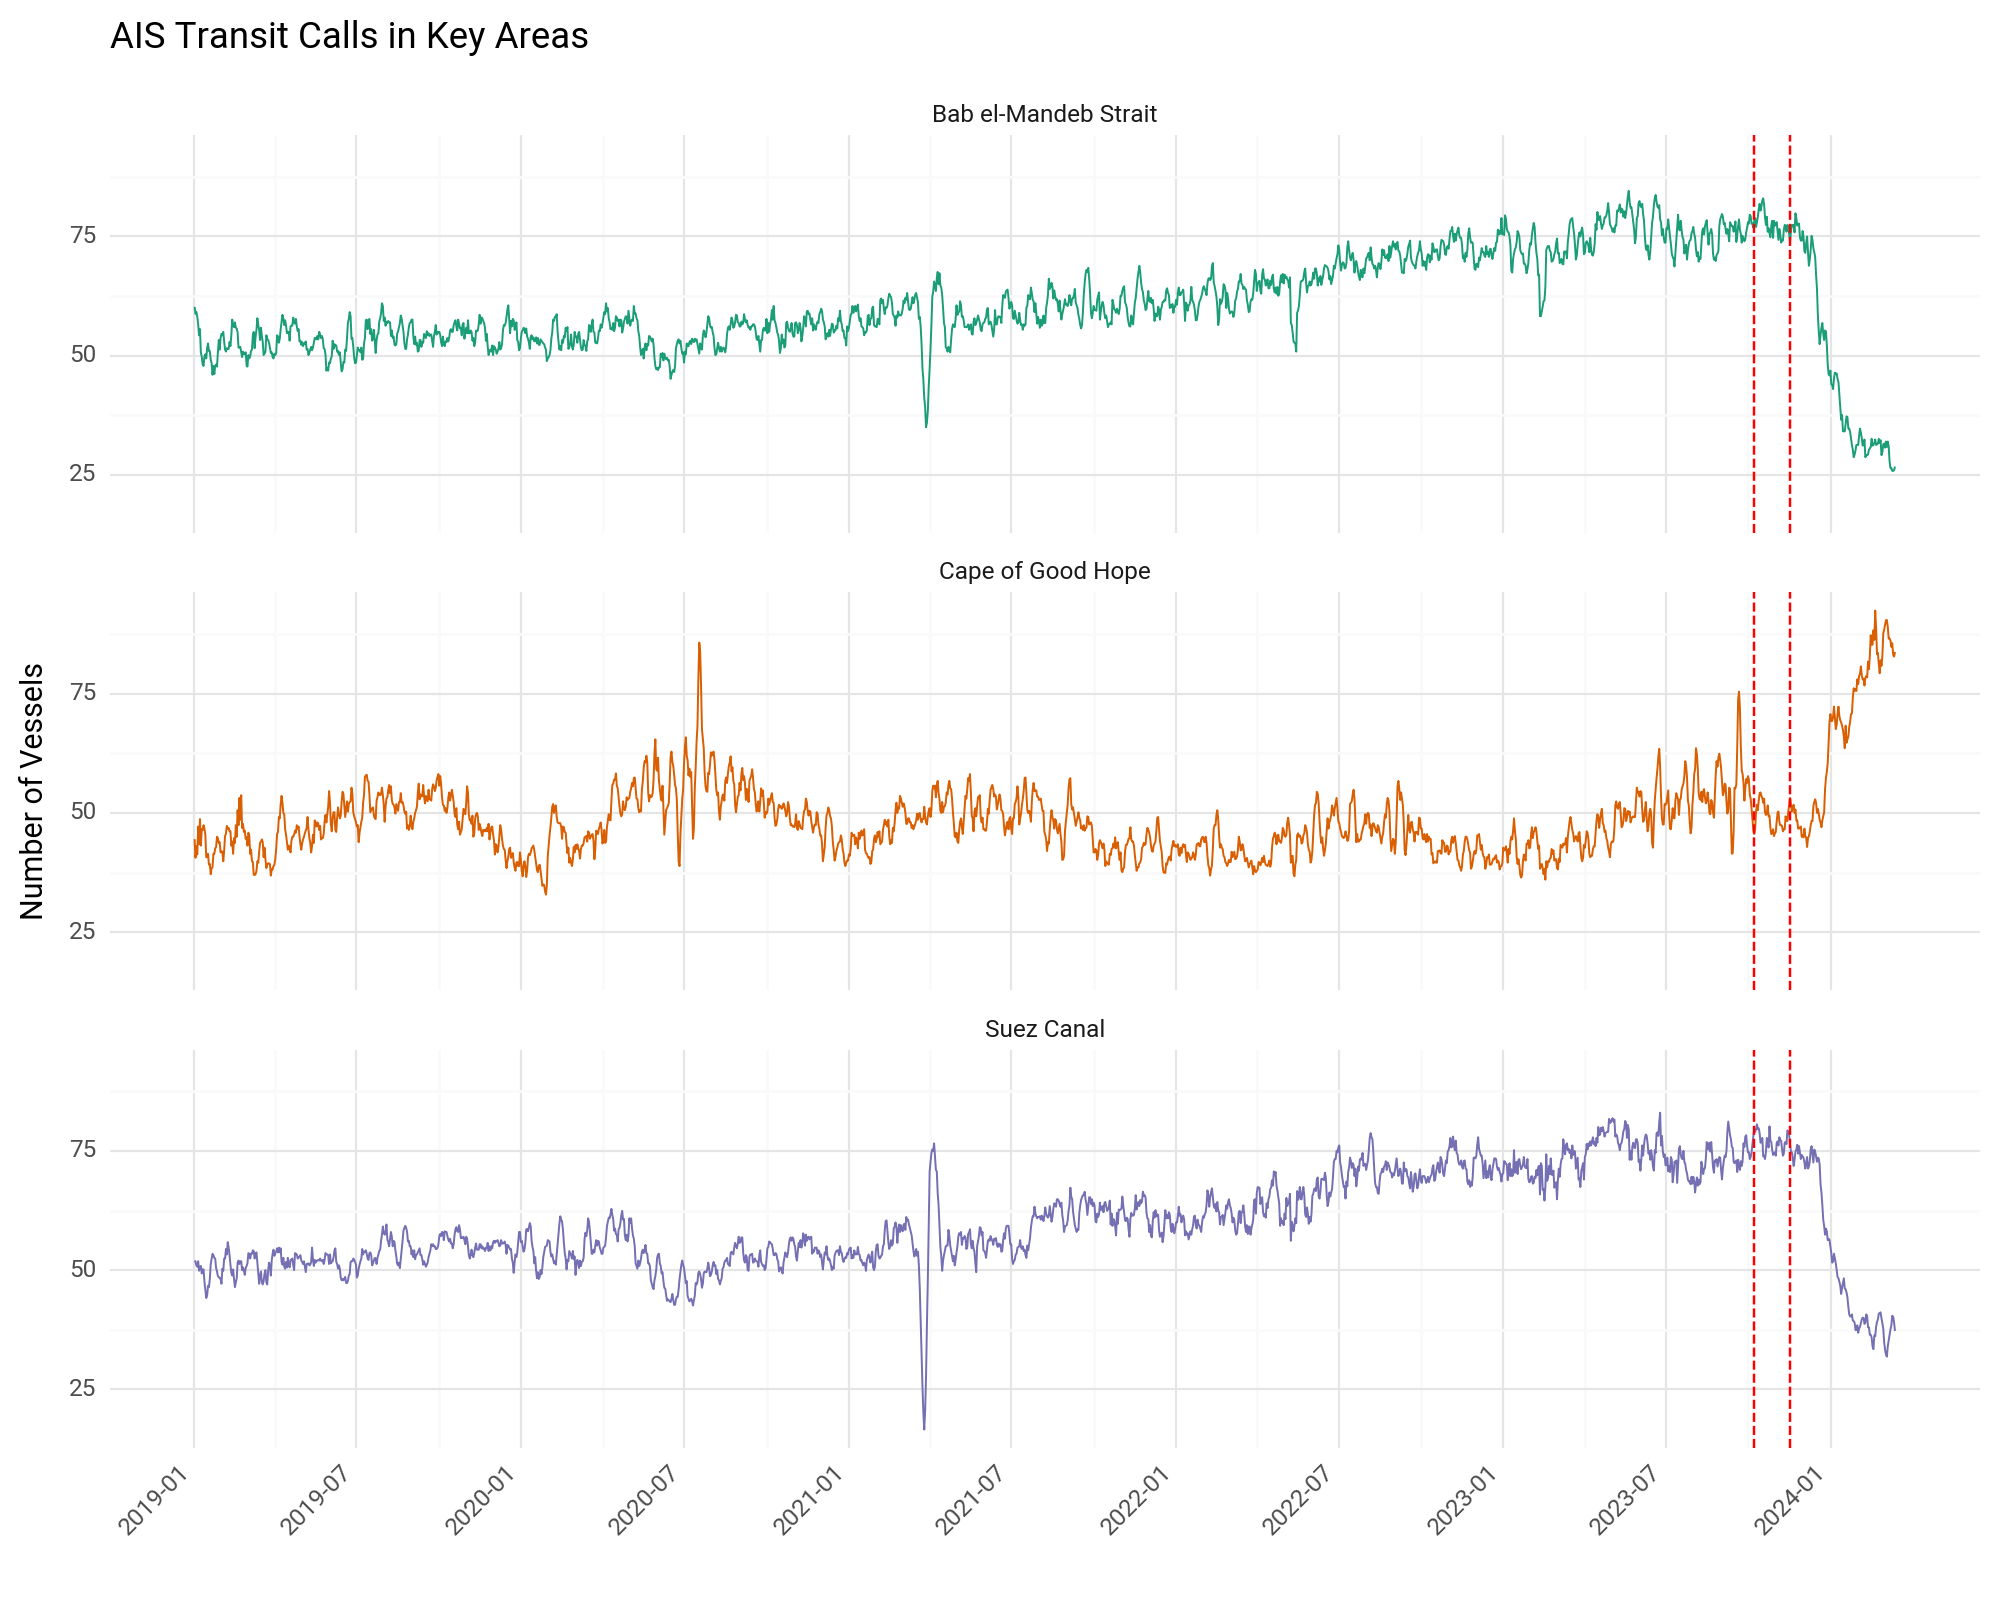

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\chokepoints\transit-calls-chokepoints-historical.jpeg


In [12]:
p0 = (
    ggplot(df, aes(x="date", y="n_total", group="portname", color="portname"))  #
    + geom_line(alpha=1, size=0.4)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + labs(
        x="",
        y="Number of Vessels",
        title="AIS Transit Calls in Key Areas",
        color="Area of Interest",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_x_datetime(breaks=date_breaks("6 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position="none")
    + facet_wrap("~portname", scales="fixed", ncol=1)
)
display(p0)
p0.save(
    filename=join(
        charts_dir, "chokepoints", "transit-calls-chokepoints-historical.jpeg"
    ),
    dpi=300,
)

### Calculate Reference Values

Periods
- **Baseline**: 2021, 2022, 2023 (January 1st – October 6th)
- **Middle East Conflict**: 2023 (October 7th - November 16th)
- **Red Sea Crisis**: November 17th - January 31st, 2024

In [13]:
start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [14]:
df_ref = df.loc[(df.date >= start_reference_date) & (df.date < conflict_date)].copy()
df_ref = df_ref.groupby(["portname", "md"])[
    ["n_tanker", "n_cargo", "n_total", "capacity"]
].mean()
df_ref.reset_index(inplace=True)
df_ref.rename(
    columns={
        "n_tanker": "n_tanker_ref",
        "n_cargo": "n_cargo_ref",
        "n_total": "n_total_ref",
        "capacity": "capacity_ref",
    },
    inplace=True,
)

Filter recent data (2023 onwards) and merge reference values.

In [15]:
df_filt = df.loc[(df.date >= "2023-01-01")].copy()
df_filt = df_filt.merge(df_ref, on=["portname", "md"], how="left", validate="m:1")

Calculate percentage change.

In [16]:
df_filt.loc[:, "n_total_pct_ch"] = df_filt.apply(
    lambda x: (x.n_total - x.n_total_ref) / (x.n_total_ref), axis=1
)

In [17]:
df_filt = df_filt.loc[~(df_filt.ymd == "2024-02-29")].copy()

### Figure: AIS Transit Calls in Key Areas

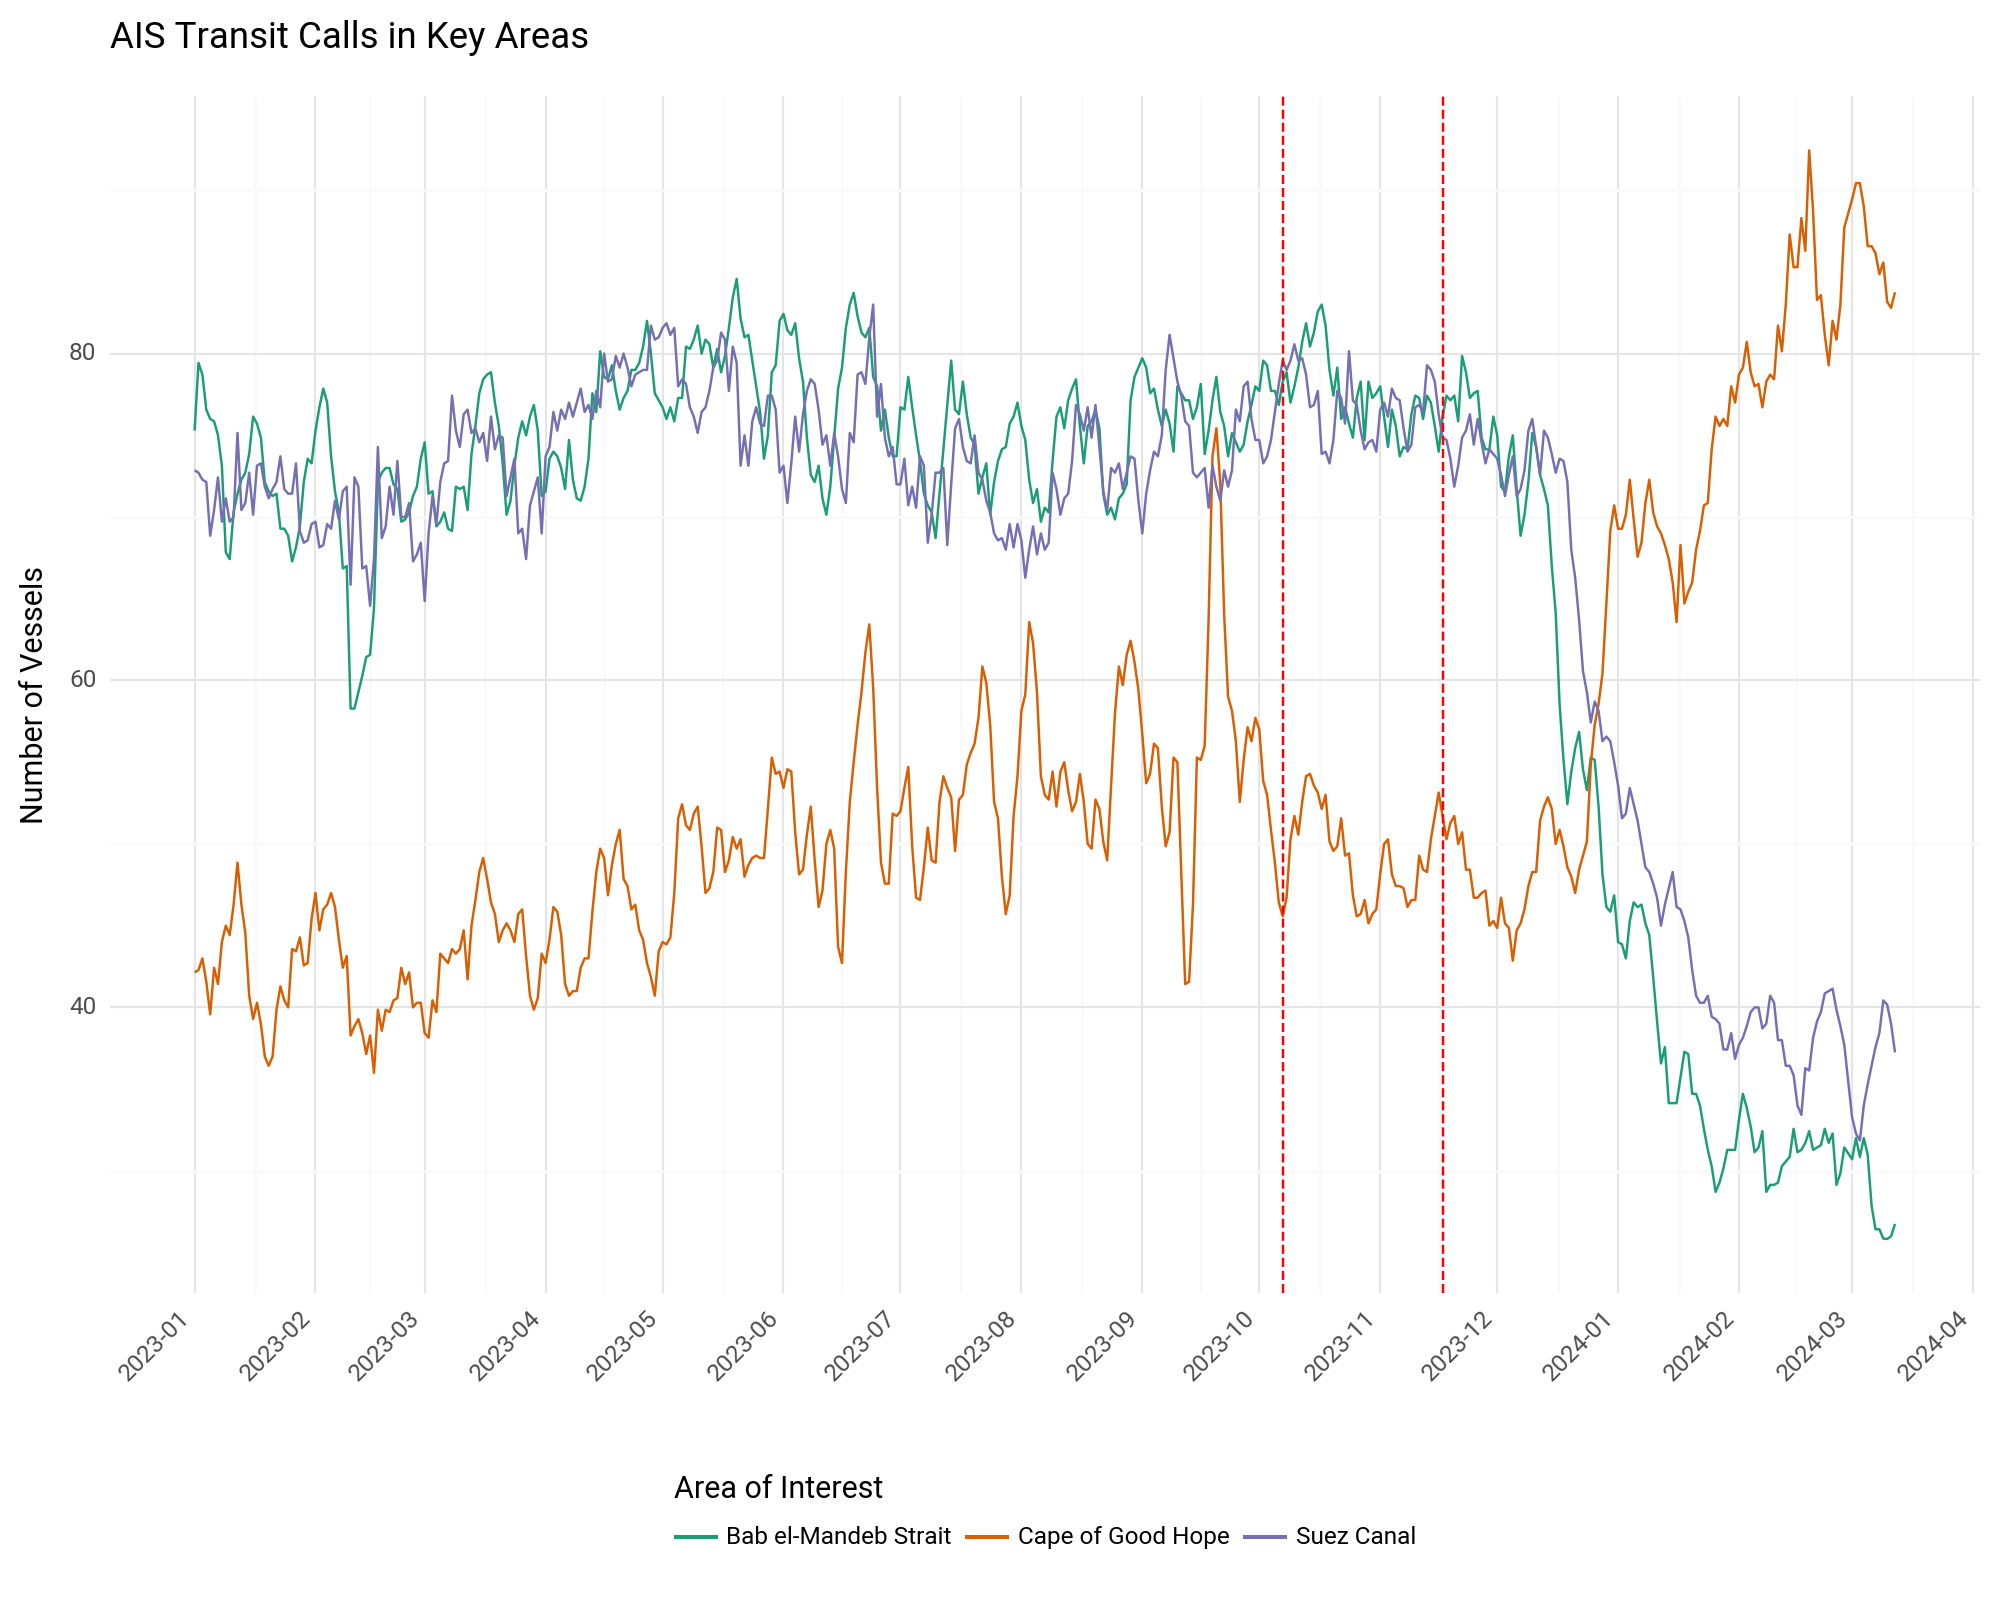

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\chokepoints\transit-calls-chokepoints.jpeg


In [18]:
p1 = (
    ggplot(df_filt, aes(x="ymd", y="n_total", group="portname", color="portname"))  #
    + geom_line(alpha=1)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + labs(
        x="",
        y="Number of Vessels",
        title="AIS Transit Calls in Key Areas",
        color="Area of Interest",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + theme(legend_position="bottom")
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
display(p1)
p1.save(
    filename=join(charts_dir, "chokepoints", "transit-calls-chokepoints.jpeg"), dpi=300
)

### Figure: AIS Transit Calls Relative to Historical Average

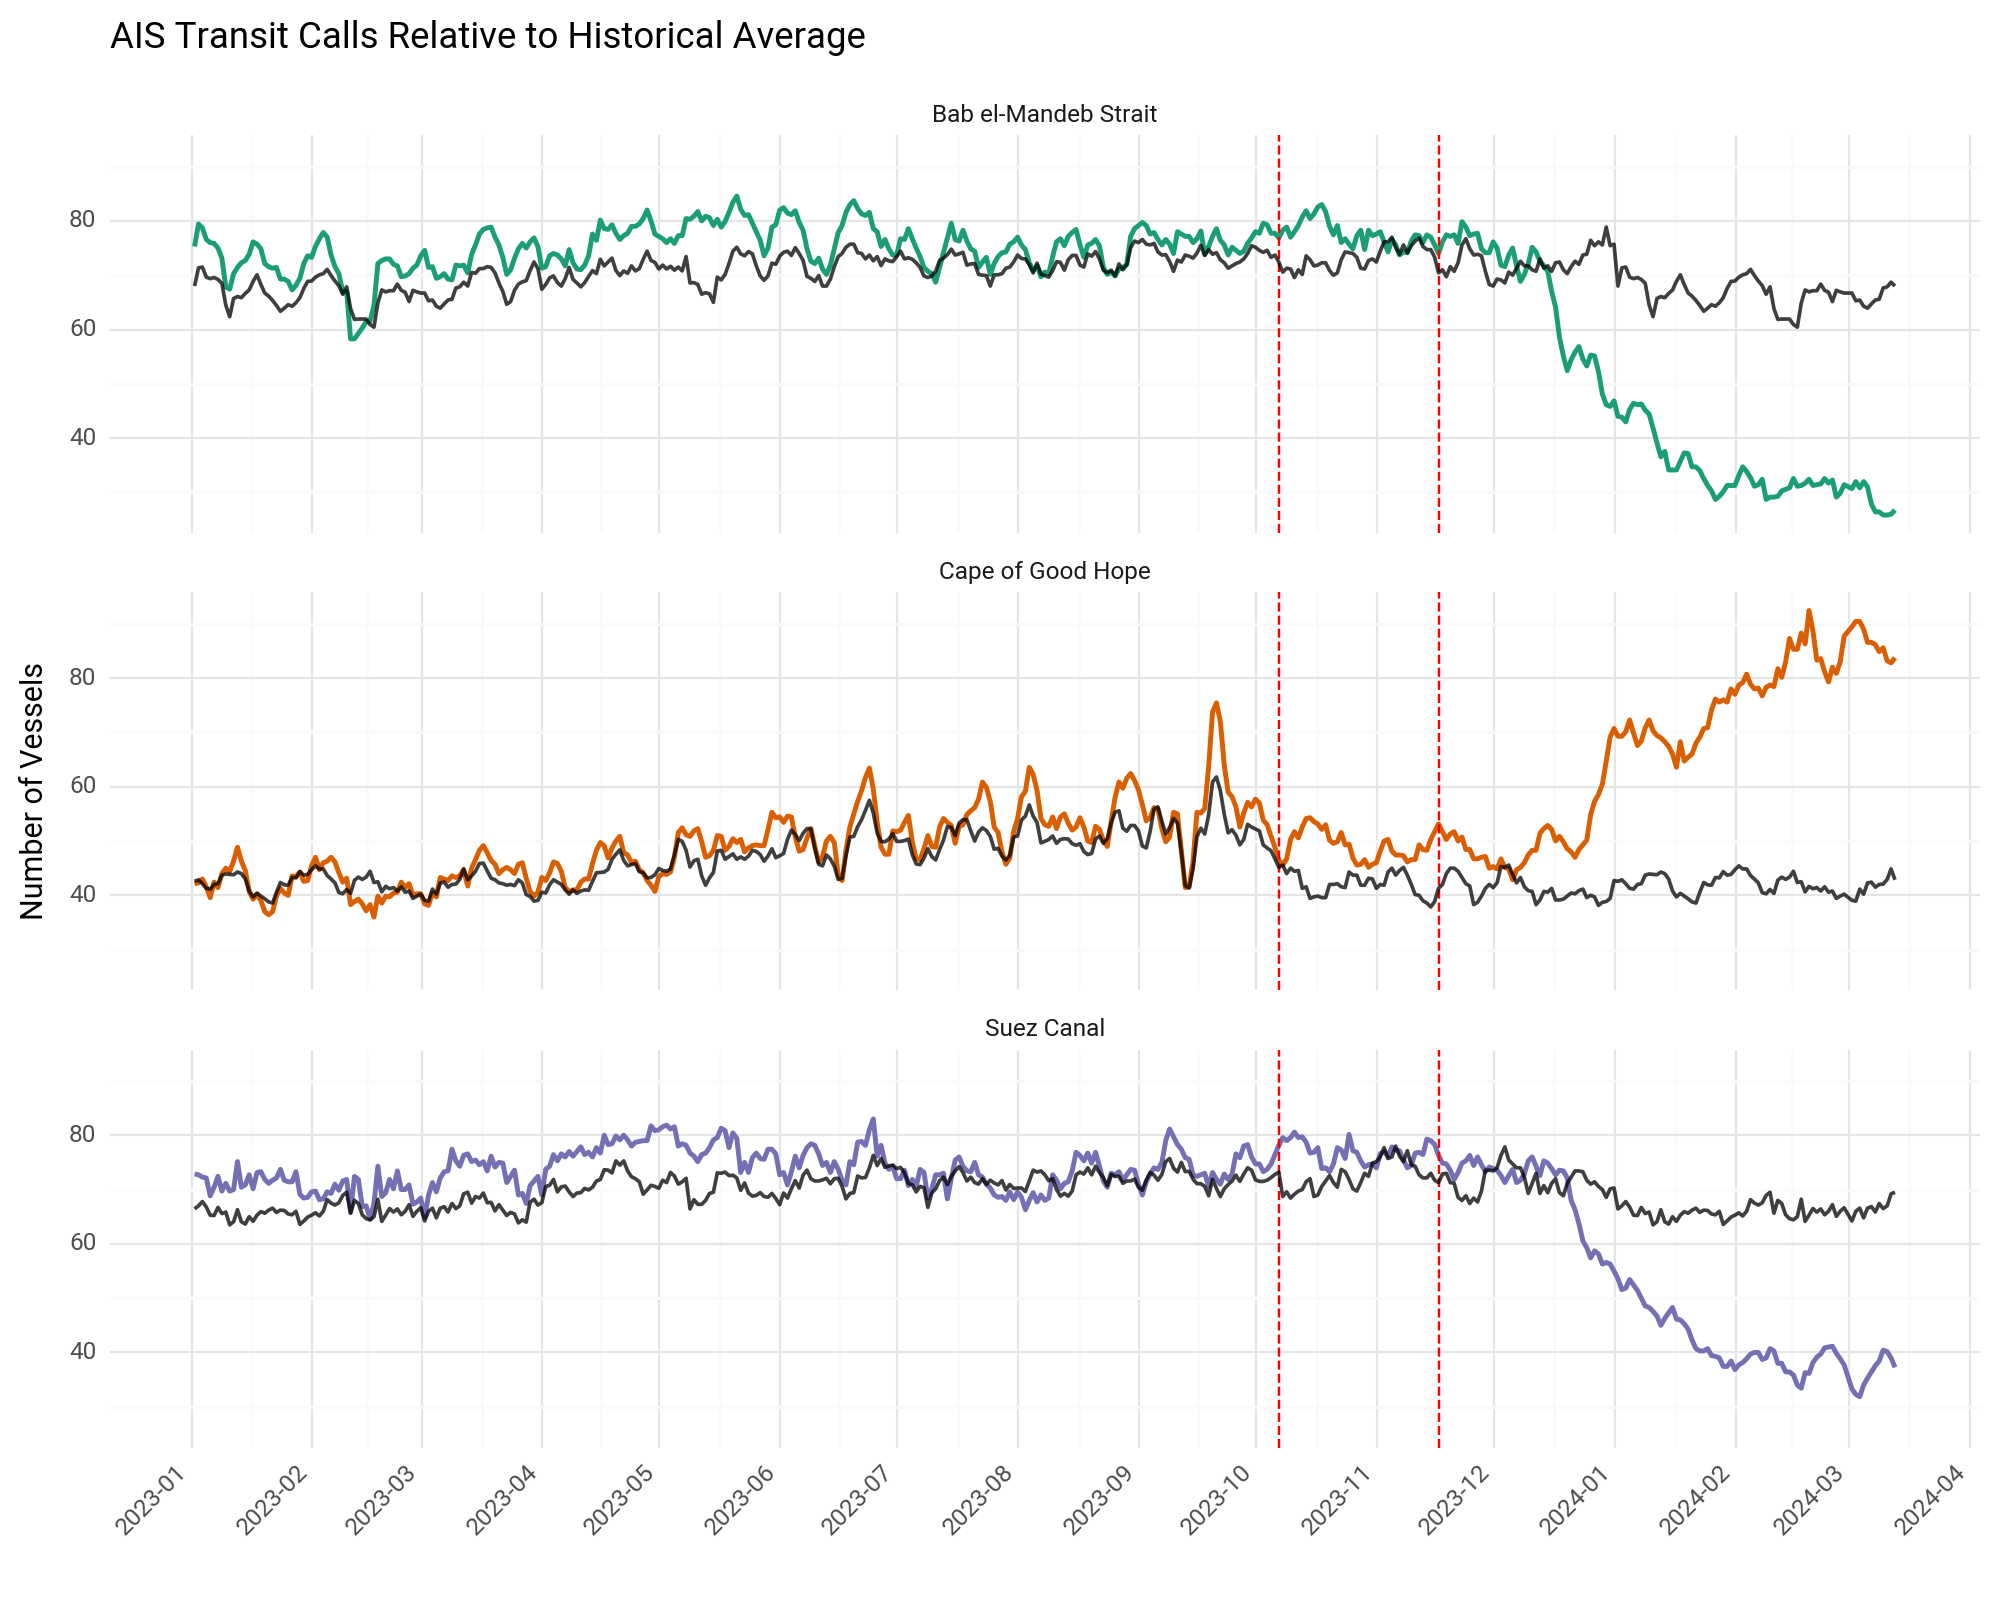

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\chokepoints\transit-calls-chokepoints-ref.jpeg


In [19]:
p2 = (
    ggplot(df_filt, aes(x="date", y="n_total", group="portname", color="portname"))  #
    + geom_line(size=1)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + geom_line(
        aes(x="date", y="n_total_ref", group="portname"),
        color="black",
        size=0.75,
        alpha=3 / 4,
    )
    + labs(
        x="",
        y="Number of Vessels",
        title="AIS Transit Calls Relative to Historical Average",
        color="Area of Interest",
    )
    + theme_minimal()
    + theme(text=element_text(family="Roboto"))
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    # + scale_y_continuous(labels=comma_format())
    + theme(legend_position="none")
    + facet_wrap("~portname", scales="fixed", ncol=1)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
display(p2)
p2.save(
    filename=join(charts_dir, "chokepoints", "transit-calls-chokepoints-ref.jpeg"),
    dpi=300,
)

### Figure: AIS Transit Calls % Change from Historical Average

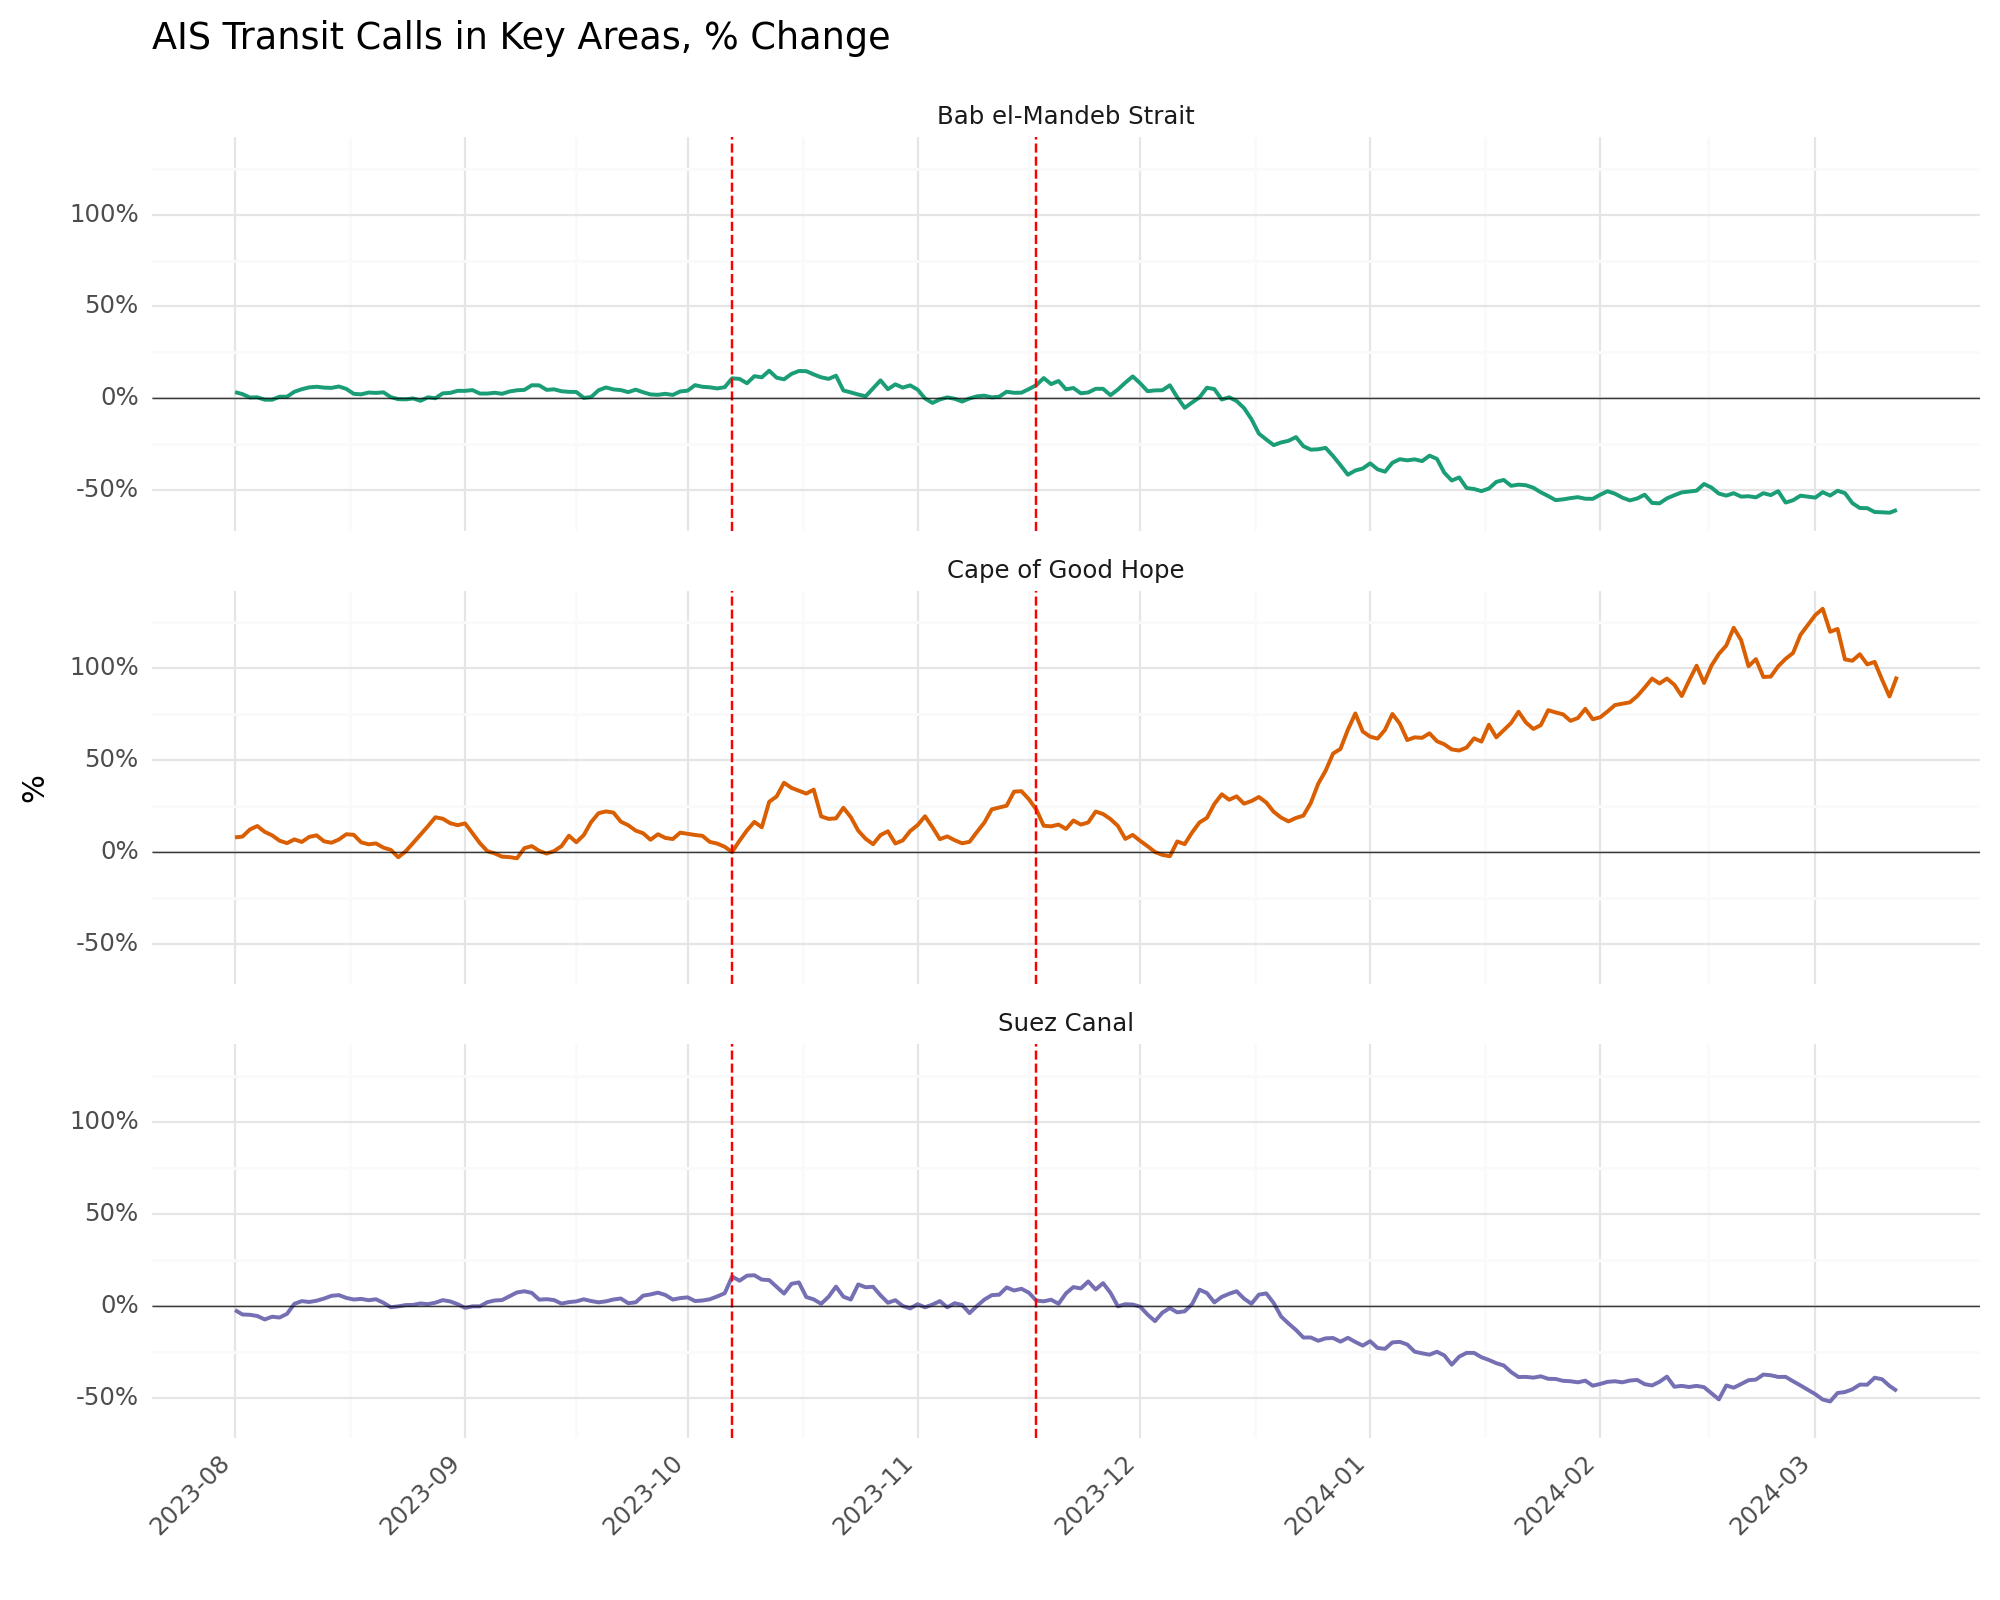

<Figure Size: (1000 x 800)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 10 x 8 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\chokepoints\transit-calls-chokepoints-pct.jpeg


In [20]:
p3 = (
    ggplot(
        df_filt.loc[df_filt.date >= "2023-08-01"],
        aes(x="ymd", y="n_total_pct_ch", group="portname", color="portname"),
    )  #
    + geom_line(size=0.8)
    + geom_vline(xintercept=conflict_date, linetype="dashed", color="red")
    + geom_vline(xintercept=crisis_date, linetype="dashed", color="red")
    + geom_hline(yintercept=0, color="black", alpha=3 / 4, size=0.3)
    + labs(
        x="",
        y="%",
        title="AIS Transit Calls in Key Areas, % Change",
        color="Area of Interest",
    )
    + theme_minimal()
    + scale_x_datetime(breaks=date_breaks("1 month"), labels=date_format("%Y-%m"))
    + scale_color_brewer(type="qual", palette=2)
    + scale_y_continuous(labels=percent_format())
    + theme(legend_position="none")
    + facet_wrap("~portname", scales="fixed", ncol=1)
    + theme(axis_text_x=element_text(rotation=45, hjust=1))
)
display(p3)
p3.save(
    filename=join(charts_dir, "chokepoints", "transit-calls-chokepoints-pct.jpeg"),
    dpi=300,
)

## Summary Statistics

Calculate average values by location and time period.

In [21]:
conflict_date, crisis_date

('2023-10-07', '2023-11-17')

In [22]:
df.loc[:, "period"] = ""
df.loc[
    (df.date >= start_reference_date) & (df.date < crisis_date), "period"
] = "Reference"
df.loc[
    (df.date >= conflict_date) & (df.date < crisis_date), "period"
] = "Middle East Conflict"
df.loc[(df.date >= crisis_date), "period"] = "Red Sea Crisis"

In [24]:
df_agg = (
    df.loc[df.period != ""]
    .groupby(["portname", "period"])[["n_tanker", "n_cargo", "n_total", "capacity"]]
    .mean()
)

# change order of rows
df_agg = df_agg.reindex(
    ["Reference", "Middle East Conflict", "Red Sea Crisis"], level=1
)

### Table: Daily Average Values by Time Period

In [25]:
table = df_agg.copy()
# format column numbers to 2 decimal places only for first three columns
table.iloc[:, :3] = table.iloc[:, :3].applymap(lambda x: "{:.2f}".format(x))

# format last column numbers to thousands
table.loc[:, "capacity"] = table.capacity.apply(lambda x: "{:,.0f}".format(x))

table.rename(
    columns={
        "n_tanker": "Tankers",
        "n_cargo": "Cargo",
        "n_total": "Total",
        "capacity": "Capacity",
    },
    inplace=True,
)
table.index.names = ["Area of Interest", "Period"]
display(table)

C:\Users\WB514197\AppData\Local\Temp\ipykernel_32444\467821549.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Tankers  Cargo  Total   Capacity
Area of Interest     Period                                               
Bab el-Mandeb Strait Reference              23.91  46.86  70.77  4,823,326
                     Middle East Conflict   25.95  51.58  77.53  5,305,603
                     Red Sea Crisis         16.61  29.66  46.27  2,827,859
Cape of Good Hope    Reference               9.34  36.68  46.01  4,380,133
                     Middle East Conflict   10.03  39.20  49.23  4,813,646
                     Red Sea Crisis         14.73  52.64  67.38  6,060,882
Suez Canal           Reference              23.09  46.98  70.07  4,737,291
                     Middle East Conflict   25.20  51.64  76.83  5,246,677
                     Red Sea Crisis         17.12  34.95  52.07  3,201,821

In [26]:
df_agg_copy = df_agg.copy()

In [27]:
res = []
for aoi in aois:
    df_sub = df_agg_copy.loc[(aoi), :].transpose().copy()
    df_sub.loc[:, "Middle East Conflict"] = (
        df_sub.loc[:, "Middle East Conflict"] - df_sub.loc[:, "Reference"]
    ) / df_sub.loc[:, "Reference"]
    df_sub.loc[:, "Red Sea Crisis"] = (
        df_sub.loc[:, "Red Sea Crisis"] - df_sub.loc[:, "Reference"]
    ) / df_sub.loc[:, "Reference"]
    df_sub2 = df_sub.transpose()
    df_sub2.drop("Reference", inplace=True)
    df_sub2.loc[:, "portname"] = aoi
    res.append(df_sub2)

In [28]:
df_agg_pct = pd.concat(res)

### Table: Daily Average Values by Time Period, % Change from Baseline

In [29]:
df_agg_pct.reset_index(inplace=True)
df_agg_pct.set_index(["portname", "period"], inplace=True)

# format columns as pct
df_agg_pct = df_agg_pct.applymap(lambda x: "{:.2%}".format(x))
df_agg_pct.rename(
    columns={
        "n_tanker": "Tankers",
        "n_cargo": "Cargo",
        "n_total": "Total",
        "capacity": "Capacity",
    },
    inplace=True,
)
df_agg_pct.index.names = ["Area of Interest", "Period"]
display(df_agg_pct)

C:\Users\WB514197\AppData\Local\Temp\ipykernel_32444\3184510119.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Tankers    Cargo    Total Capacity
Area of Interest     Period                                                  
Bab el-Mandeb Strait Middle East Conflict    8.56%   10.08%    9.56%   10.00%
                     Red Sea Crisis        -30.51%  -36.70%  -34.61%  -41.37%
Cape of Good Hope    Middle East Conflict    7.42%    6.87%    6.98%    9.90%
                     Red Sea Crisis         57.81%   43.53%   46.43%   38.37%
Suez Canal           Middle East Conflict    9.12%    9.91%    9.65%   10.75%
                     Red Sea Crisis        -25.86%  -25.61%  -25.69%  -32.41%

Save tables to excel

In [31]:
with pd.ExcelWriter(
    join(
        output_dir,
        "tables",
        f'summary-tables-chokepoints-{time.strftime("%Y_%m_%d")}.xlsx',
    )
) as writer:
    table.to_excel(writer, sheet_name="Chokepoints Summary")
    df_agg_pct.to_excel(writer, sheet_name="Chokepoints % Change")